In [6]:
from math_verify import parse, verify
import re
import pandas as pd
import torch
import json

In [58]:
df = pd.read_parquet("../../open-math-reasoning/sample_c7_300_results_repeat_16.parquet")
prompt_to_embed = torch.load("../../open-math-reasoning/sample_c7_300_problem_last_hidden_states.pt")
problem_to_embed = {key.split("<|im_start|>user\n")[-1].split("<|im_end|>\n<|im_start|>assistant\n")[0]: value for key, value in prompt_to_embed.items()}

In [59]:
def extract_last_boxed_greedy(text):
    if not text:
        return None

    positions = [m.start() for m in re.finditer(r'\\boxed\{', text)]
    if not positions:
        return None

    last_pos = positions[-1]
    rest_of_text = text[last_pos:]
    match = re.match(r'\\boxed\{((?:[^{}]|\{[^{}]*\})*)\}', rest_of_text)
    if match:
        return match.group(1)

    return None

In [60]:
problem_to_pass_rate = {}
for problem in df.problem.unique():
    df_problem = df[df.problem == problem]
    gold = parse(df_problem.expected_answer.tolist()[0])
    num_pass = 0
    num_total = 0
    for response in df_problem.response:
        num_total += 1
        if verify(gold, parse(extract_last_boxed_greedy(response))):
            num_pass += 1
    problem_to_pass_rate[problem] = num_pass / num_total

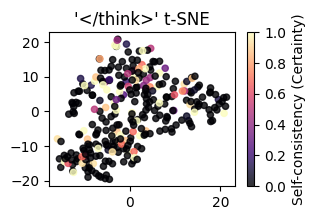

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 模拟一些数据
np.random.seed(42)
X = torch.stack([problem_to_embed[problem] for problem in problem_to_pass_rate.keys()])
y = torch.tensor([problem_to_pass_rate[problem] for problem in problem_to_pass_rate.keys()])

# t-SNE 降维
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(3, 2))
plt.tight_layout(pad=0)
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='magma', s=20, alpha=0.8)
plt.colorbar(sc, label="Self-consistency (Certainty)")
plt.title("'</think>' t-SNE")
# remove tick labels
plt.show()

In [25]:
problem_to_embed["Find a basis for the space of polynomials \\( p(x) \\) of degree less than or equal to 3."].shape

torch.Size([4096])